In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product

from copy import deepcopy
from tqdm.notebook import tqdm
import ordpy
from scipy.stats import mode, ks_2samp

In [2]:
def runge_kutta(time_steps, y0, system, params):
    ys = [y0]
    for t in range(len(time_steps)-1):
        dt = time_steps[t+1]-time_steps[t]
        t0 = time_steps[t]
        t1 = time_steps[t+1]
        k1 = system(t0, y0, params)
        k2 = system(t0 + dt/2, y0 + dt / 2 * k1, params)
        k3 = system(t0 + dt/2, y0 + dt / 2 * k2, params)
        k4 = system(t1, y0 + dt * k3, params)
        y0  = y0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        ys.append(y0)
    return np.array(ys)

def lorentz_ode(t, xyz, params):
    x, y, z = xyz
    σ = params['σ']
    ρ = params['ρ']
    β = params['β']
    
    dx = σ * (y - x)
    dy = x * (ρ - z) - y
    dz = x * y - β * z
    
    return np.array([dx, dy, dz])

def get_data(p1 = 10., p2 = 28., p3 = 8/3):
    time_steps = np.arange(0, 1500, 0.1)
    params = {'σ' : p1, 'ρ' : p2, 'β' : p3}
    xyz0 = np.array([1., 1., 1.])
    lorenz_solution = runge_kutta(time_steps, xyz0, lorentz_ode, params)
    x, y, z = lorenz_solution[2000:].T

    x = (x - min(x)) / (max(x) - min(x))
    return x

In [3]:
params = (10., 28., 8/3)

x = get_data(*params)
points_number = x.shape[0]

In [4]:
# Hyper params
L = 4 # length of pattern
K = 10 # maximal value of pattern element

step = 50 # right shift value
M = 10 # iterations number

predicted_points_number = 50

In [5]:
# Builds matrix of patterns
z_vectors = np.array(list(product(np.arange(1, K + 1), repeat=L)))
patterns = np.cumsum(z_vectors, axis=1)
patterns = np.hstack([np.zeros((z_vectors.shape[0], 1)), patterns]).astype(int)

In [6]:
# Compute motives for train_data vector based on train_points number form point start

def fit(train_data, train_points_number, start, current_iter=1, max_iter=1):
    global patterns

    z_vectors_list = []
    for i in tqdm(range(patterns.shape[0]), desc=f"Computing matrix of Z-vectors, iteration {current_iter}/{max_iter}", leave=False):
        pattern = patterns[i]
        vecs = []
        for j in range(train_points_number - pattern[-1]):
            vecs.append(train_data[pattern + j + start])
        z_vectors_list.append(np.array(vecs))
    return z_vectors_list

In [7]:
# Normalizing matrix

def norm(a):
    return np.sqrt(np.sum(np.square(a), axis=1))

In [8]:
# Predictions on train_data based on motives list by predicted_points_number points
# with max_dist between vectors and maximal allowed MAPE max_mape

def predict_with_demon(train_data, motives_list, begin, predicted_points_number, max_dist=0.05, max_mape=0.05):
  global patterns

  x_with_predictions = deepcopy(train_data) # copy of train_data with predictions
  for T in tqdm(range(begin, begin + predicted_points_number), desc="Demon predictions", leave=False):
      St = []
      # for i in tqdm(range(patterns.shape[0]), desc="Inner loop", leave=False):
      for i in range(patterns.shape[0]):
          for motive in motives_list:
            normalized_predicted = norm(motive[i][:, :-1] - x_with_predictions[(patterns[i] + T - patterns[i][-1])[:-1]])
            St.extend(motive[i][(normalized_predicted < max_dist), :][:, -1])
      if len(St) == 0:
         predicted_value = np.inf
      else:
         predicted_value = mode(St, keepdims=True).mode[0]
         if abs(predicted_value - train_data[T]) / train_data[T] > max_mape:
            predicted_value = np.inf
      x_with_predictions[T] = predicted_value
  return x_with_predictions[begin : begin + predicted_points_number]

In [9]:
def calculate_metrics(data, begin, train_points_number):
    global x
    
    c, e = [], []
    for i in range(M):
        A = ordpy.complexity_entropy(data[begin + step * i : begin + step * i + train_points_number], dx=5)
        c.append(A[0])
        e.append(A[1])
    return np.mean(np.array(c)), np.mean(np.array(e)), ks_2samp(x, data)

In [10]:
def calculate(train_points_number, y_params, begin, max_dist=0.05):
    y = get_data(*y_params)

    actual_vals_matrix = []
    predicted_vals_matrix = []

    for i in tqdm(range(M), "Overall iterations loop"):
        start = begin + step * i

        actual_vals = x[start + train_points_number : start + train_points_number + predicted_points_number]
        predicted_vals = predict_with_demon(x, [fit(x, train_points_number, start, i + 1, M), fit(y, train_points_number, start, i + 1, M)], start + train_points_number, predicted_points_number, max_dist)

        actual_vals_matrix.append(actual_vals)
        predicted_vals_matrix.append(predicted_vals)

    actual_vals_matrix = np.array(actual_vals_matrix)
    predicted_vals_matrix = np.array(predicted_vals_matrix)

    loss = np.zeros((predicted_points_number))
    unpredicted_points = np.zeros((predicted_points_number))

    for i in range(M):
        for j in range(predicted_points_number):
            if predicted_vals_matrix[i][j] == np.inf:
                unpredicted_points[j] += 1
            else:
                loss[j] += abs(predicted_vals_matrix[i][j] - actual_vals_matrix[i][j]) * 100 / actual_vals_matrix[i][j]
    loss /= M
    unpredicted_points /= M

    metrics = calculate_metrics(y, begin, train_points_number)

    return ((actual_vals_matrix, predicted_vals_matrix), (loss, unpredicted_points), metrics)

In [11]:
def plots(train_points_number, loss, unpredicted_points, params=(10., 28., 8/3)):
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(f"Trained on original series + alike series ({', '.join(map(str, [round(x, 3) for x in params]))}), train_size={train_points_number}+{train_points_number}")

    plt.subplot(1, 2, 1)
    plt.title("MAPE, %")
    plt.plot(loss)

    plt.subplot(1, 2, 2)
    plt.ylim((-0.1, 1.1))
    plt.title("Unpredicted points")
    plt.plot(unpredicted_points)

    plt.show()

In [12]:
train_points_number = 2500
begin = 7500

First mixing

In [ ]:
params1 = (params[0] * 0.99, params[1], params[2])

data1 = calculate(train_points_number, params1, begin)

Complexity: 0.5571530924868822, entropy: 0.3896778691662248, Kolmogorov metric: 0.013230769230769268


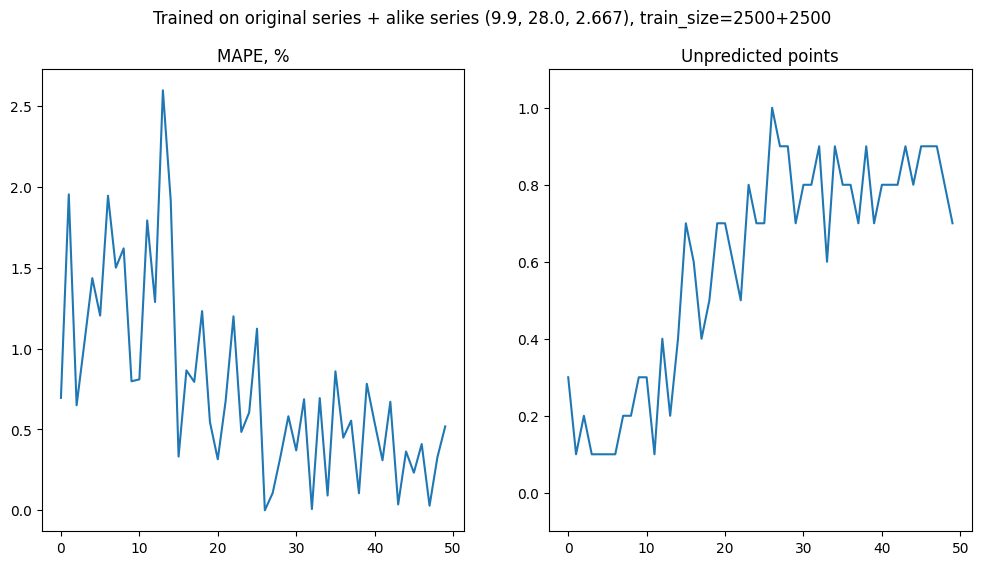

In [15]:
print(f"Complexity: {data1[2][0]}, entropy: {data1[2][1]}, Kolmogorov metric: {data1[2][2][0]}")
plots(train_points_number, data1[1][0], data1[1][1], params1)

In [16]:
np.mean(data1[1][1])

0.5940000000000001

Second mixing

In [ ]:
params2 = (params[0], params[1] * 1.01, params[2])

data2 = calculate(train_points_number, params2, begin)

Complexity: 0.5519445021884093, entropy: 0.38659735843367216, Kolmogorov metric: 0.024076923076923107


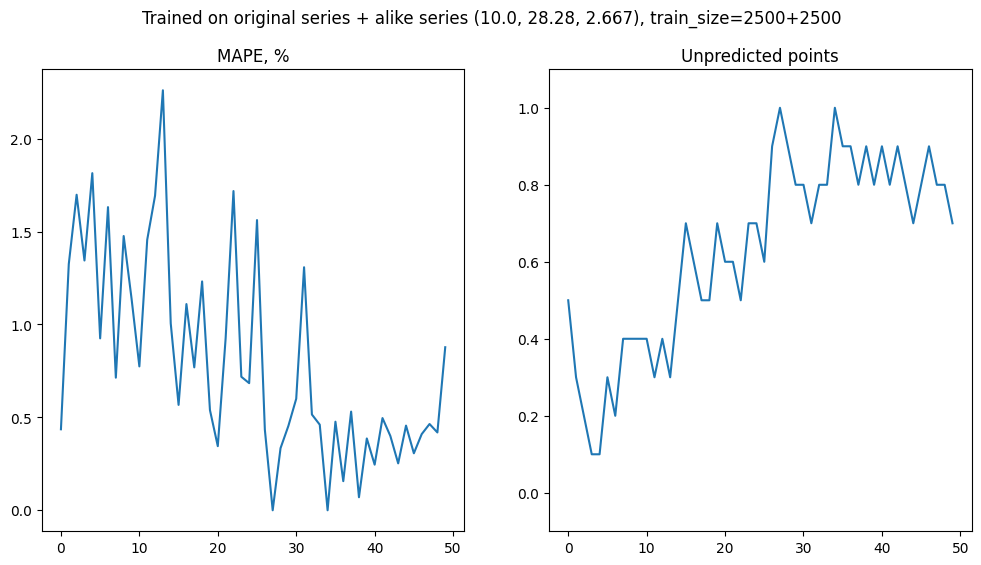

In [18]:
print(f"Complexity: {data2[2][0]}, entropy: {data2[2][1]}, Kolmogorov metric: {data2[2][2][0]}")
plots(train_points_number, data2[1][0], data2[1][1], params2)

In [19]:
np.mean(data2[1][1])

0.6319999999999999

Third mixing

In [ ]:
params3 = (params[0], params[1], params[2] * 0.98)

data3 = calculate(train_points_number, params3, begin)

Complexity: 0.5517755256253246, entropy: 0.38569083819685934, Kolmogorov metric: 0.04976923076923079


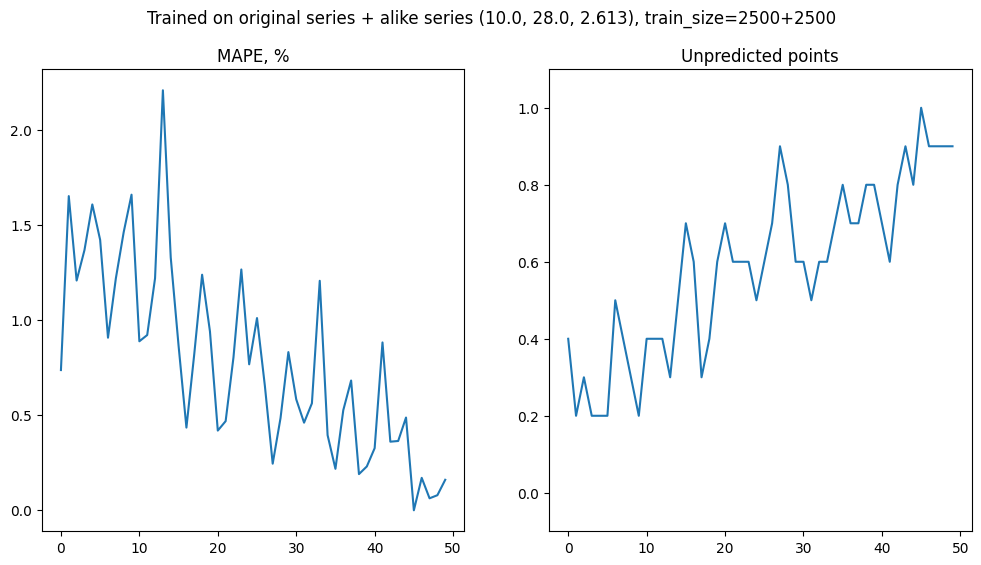

In [21]:
print(f"Complexity: {data3[2][0]}, entropy: {data3[2][1]}, Kolmogorov metric: {data3[2][2][0]}")
plots(train_points_number, data3[1][0], data3[1][1], params3)

In [22]:
np.mean(data3[1][1])

0.586

Mixing 4

In [ ]:
params4 = (params[0] * 0.99, params[1] * 1.01, params[2] * 0.98)

data4 = calculate(train_points_number, params4, begin)

Complexity: 0.5576980444722623, entropy: 0.38736056653079576, Kolmogorov metric: 0.05799999999999994


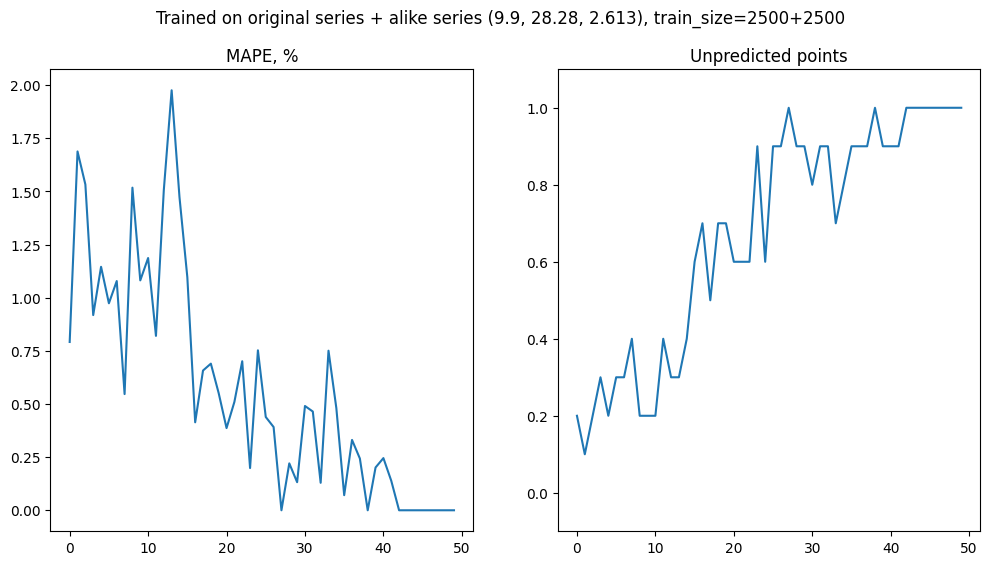

In [24]:
print(f"Complexity: {data4[2][0]}, entropy: {data4[2][1]}, Kolmogorov metric: {data4[2][2][0]}")
plots(train_points_number, data4[1][0], data4[1][1], params4)

In [25]:
np.mean(data4[1][1])

0.672

Mixing 5

In [ ]:
params5 = (params[0] * 1.02, params[1] * 0.99, params[2] * 1.01)

data5 = calculate(train_points_number, params5, begin)

Complexity: 0.5650572871234985, entropy: 0.3949311864658328, Kolmogorov metric: 0.04176923076923078


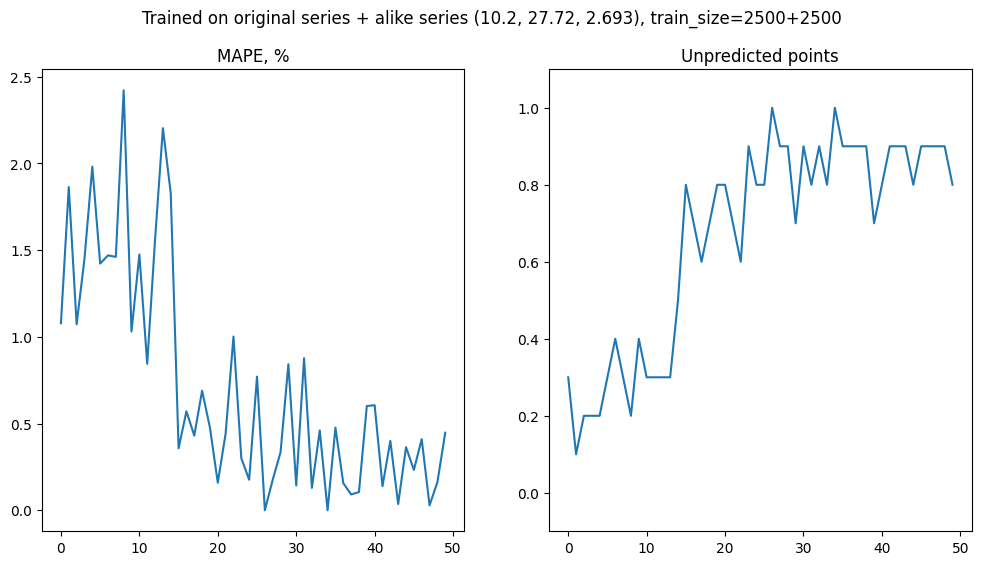

In [27]:
print(f"Complexity: {data5[2][0]}, entropy: {data5[2][1]}, Kolmogorov metric: {data5[2][2][0]}")
plots(train_points_number, data5[1][0], data5[1][1], params5)

In [28]:
np.mean(data5[1][1])

0.6679999999999999

Mixing 6

In [ ]:
params6 = (params[0] * 0.99, params[1] * 1.02, params[2] * 0.98)

data6 = calculate(train_points_number, params6, begin)

Complexity: 0.5623436961567528, entropy: 0.3911299564035339, Kolmogorov metric: 0.008846153846153837


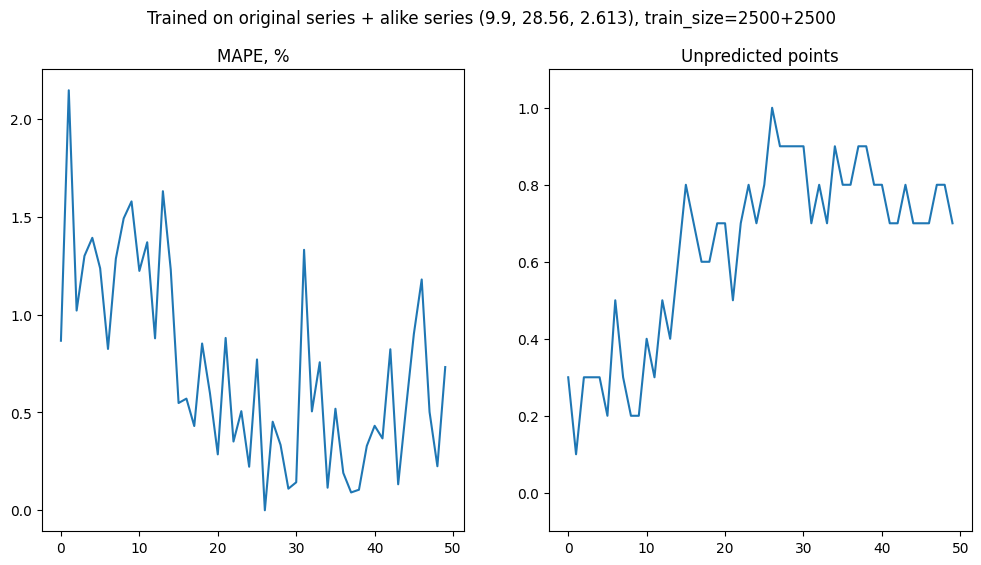

In [15]:
print(f"Complexity: {data6[2][0]}, entropy: {data6[2][1]}, Kolmogorov metric: {data6[2][2][0]}")
plots(train_points_number, data6[1][0], data6[1][1], params6)

In [16]:
np.mean(data6[1][1])

0.636

Mixing 7

In [ ]:
params7 = (params[0] * 1.02, params[1], params[2] * 1.01)

data7 = calculate(train_points_number, params7, begin)

Complexity: 0.5555422630229637, entropy: 0.3867398153173756, Kolmogorov metric: 0.0948461538461538


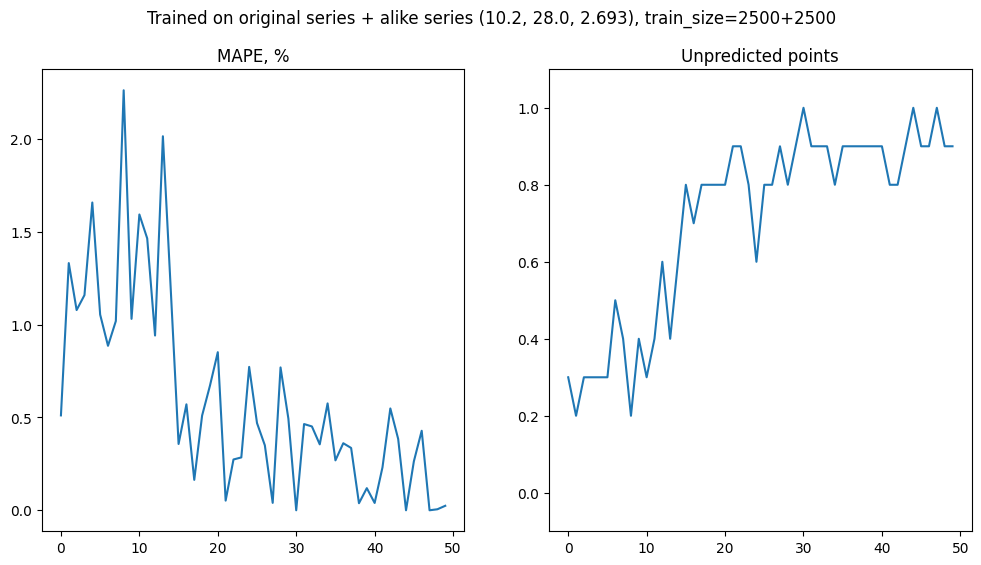

In [18]:
print(f"Complexity: {data7[2][0]}, entropy: {data7[2][1]}, Kolmogorov metric: {data7[2][2][0]}")
plots(train_points_number, data7[1][0], data7[1][1], params7)

In [19]:
np.mean(data7[1][1])

0.7119999999999999